## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import string

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from nltk.corpus import stopwords
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

import pymorphy2


import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.externals import joblib

In [2]:
import sklearn

In [6]:
print(sklearn.__version__)

0.21.3


## Загрузка и подготовка данных

In [2]:
with open('test.csv') as file:
    file = file.read()

In [3]:
len(file.split('<review>')[1:])

100

In [4]:
text = file.split('<review>')[1:]

In [5]:
new_text = []

for s in text:
    new_s = s.replace('\n</review>\n\n', '')
    new_text.append(new_s.replace('\n', ''))
    
df = pd.DataFrame(new_text)

In [6]:
df.head()

,0
0,"Ужасно слабый аккумулятор, это основной минус ..."
1,ценанадежность-неубиваемостьдолго держит батар...
2,"подробнее в комментарияхК сожалению, факт поло..."
3,я любительница громкой музыки. Тише телефона у...
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех..."


In [7]:
df.columns = ['Text']

#### разметим данные предоставленные клиентом

In [8]:
nltk_words = set(stopwords.words('russian'))

In [9]:
vectorizer = TfidfVectorizer(analyzer='char_wb', max_df=0.5, ngram_range=(3, 5), stop_words=nltk_words, 
                             sublinear_tf=True)

In [10]:
matrix = vectorizer.fit_transform(df['Text'])

In [11]:
matrix.shape

(100, 35396)

In [12]:
model= AgglomerativeClustering(n_clusters=2)
preds= model.fit_predict(matrix.toarray())

In [13]:
len(preds[preds == 1])

49

In [14]:
len(preds[preds == 0])

51

In [15]:
ind_1 = np.where(preds == 0)

In [16]:
ind_1

(array([ 1,  4,  5,  6,  7,  9, 11, 12, 13, 14, 15, 16, 18, 19, 20, 23, 24,
        27, 29, 31, 33, 35, 36, 38, 40, 41, 42, 45, 46, 47, 50, 55, 56, 57,
        58, 59, 61, 65, 68, 69, 70, 75, 77, 81, 84, 86, 90, 91, 93, 96, 98]),)

In [17]:
# разметим данные
labels = np.zeros(100)

for i in ind_1:
    labels[i] = 1
    
df['label'] = labels

In [18]:
df.head()

,Text,label
0,"Ужасно слабый аккумулятор, это основной минус ...",0.0
1,ценанадежность-неубиваемостьдолго держит батар...,1.0
2,"подробнее в комментарияхК сожалению, факт поло...",0.0
3,я любительница громкой музыки. Тише телефона у...,0.0
4,"Дата выпуска - 2011 г, емкость - 1430 mAh, тех...",1.0


#### загрузим данные собранные с "отзовиков"

In [19]:
mobile_review = pd.read_csv('mobile_reviews.csv', index_col=0)
mobile_review.head()

,review,label
0,"Экран, аккумулятор, внешний вид Процессор, кам...",0.0
1,Очень удобный как молоток Был у меня регми нот...,0.0
2,NFCЭкранАвтономностьПроизводительность Камерар...,0.0
3,1) IPS экран. Не имеет ШИМ и не портит глаза.2...,0.0
4,"Большой экран с хорошим разрешением,хорошая ка...",0.0


In [20]:
mobile_review = shuffle(mobile_review)
mobile_review.index = list(range(881))

In [21]:
mobile_review

,review,label
0,- наличие NFC модуля (после Xiaomi Redmi Note ...,0.0
1,Дизайн (белый цвет)КамераБатарейкаСкорость раб...,1.0
2,"Экран,функциональность, вид, цена. Быстро разр...",0.0
3,Естественно в этом телефоне основная переплата...,1.0
4,— Очень маленькая память для нашего времени. —,0.0
...,...,...
876,Размер экрана КАМЕРА!Отвратительная. Я использ...,0.0
877,"-Экран-Объем памяти (не ее качество!) -Камера,...",0.0
878,плюсы как и у всех смартфонов данной фирмы. ка...,0.0
879,Мощность\nКамера\nДизайн\nАвтономность\nFace I...,1.0


In [22]:
stop_words = stopwords.words('russian')

In [23]:
# def remove_punctuation(text):
#     '''a function for removing punctuation'''
#     translator = str.maketrans('', '', string.punctuation)
#     return text.translate(translator)


# def stopwords(text):
#     '''a function for removing the stopword'''
#     text = [word.lower() for word in text.split() if word.lower() not in stop_words]
#     return " ".join(text)

In [24]:
# mobile_review['review'] = mobile_review['review'].apply(remove_punctuation)
# mobile_review

In [25]:
# mobile_review['review'] = mobile_review['review'].apply(stopwords)

In [26]:
mobile_review[mobile_review.review.isna()]

,review,label
470,NaN,1.0
639,NaN,1.0


In [27]:
mobile_review['review'] = mobile_review['review'].fillna('неплохой')

In [28]:
count_vectorizer = CountVectorizer()
count_vectorizer.fit(mobile_review['review'])
dictionary = count_vectorizer.vocabulary_.items() 

In [29]:
vocab = []
count = []
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
    
vocab_bef_stem = pd.Series(count, index=vocab)
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

#### Посмотрим на самые поплурные слова

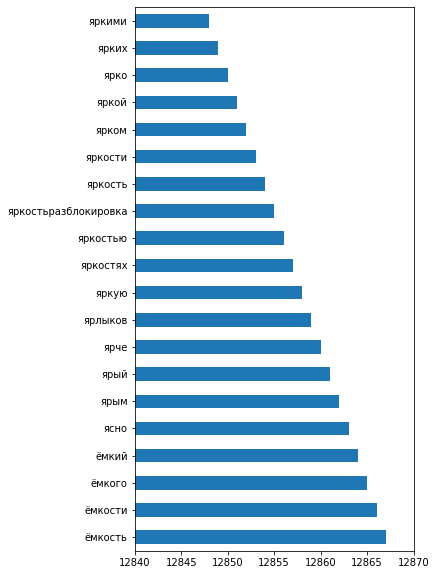

In [30]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (12840, 12870))

#### Тренировка классификатора

In [31]:
vectorizer = TfidfVectorizer(analyzer='char_wb', max_df=0.5, ngram_range=(1, 4), stop_words=nltk_words, 
                             sublinear_tf=True)
model = LinearSVC(penalty='l1', dual=False)

matrix_tfidf_test = vectorizer.fit_transform(mobile_review['review'].values.astype('U'))

matrix_tfidf_control = vectorizer.transform(df.Text.values.astype('U'))

model.fit(matrix_tfidf_test, mobile_review.label)

preds = model.predict(matrix_tfidf_control)

In [32]:
print("Оценка на контрольной выборке: %.2f " % accuracy_score(df.label, preds))

Оценка на контрольной выборке: 0.82 


Лучше всего на контрольной выборке показал себя SVC классификатор с TfidfVectorizer

In [33]:
vectorizer = TfidfVectorizer(analyzer='char_wb', max_df=0.5, ngram_range=(1, 4), stop_words=nltk_words, 
                             sublinear_tf=True)
model = LinearSVC(penalty='l1', dual=False)
final_model = Pipeline([('vectorizer', vectorizer),
                   ('model', model)])
final_model.fit(mobile_review.review, mobile_review.label)
preds = final_model.predict(df.Text)
print("Оценка на кросс-валидации: %.2f " % cross_val_score(final_model, mobile_review.review, 
                                                           mobile_review.label, cv=5, scoring='accuracy').mean())

Оценка на кросс-валидации: 0.89 


#### Натренируем модель на всех данных

In [34]:
df.columns = ['review', 'label']

In [35]:
full_data = pd.concat([df, mobile_review])
full_data = shuffle(full_data)
full_data.index = range(full_data.shape[0])

In [36]:
full_data

,review,label
0,"Батарея. Экран. iOs. Камера Нет Первый iphone,...",1.0
1,"Дизайн, Камера, удобство управления, аккумулят...",1.0
2,"качественный, доступный нет Довольно не плохой...",1.0
3,- Дисплей- Качество видео- Автономность в режи...,0.0
4,Ничего хорошего Вылетают все игры Этот телефон...,0.0
...,...,...
976,"Внешний дизайн, вес, экран, камера, цена! Нет ...",1.0
977,Камера!Шустрый процессорIPS-экранОщутимо подро...,1.0
978,Хорошая камера В остальном не очень. Заряд дер...,0.0
979,не нашел не нашел заказал здесь Смартфон Xiaom...,0.0


In [37]:
final_model.fit(full_data.review, full_data.label)

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'а', 'без', 'более', 'больше',
                                             'будет', 'будто', 'бы', '...
                                             'вы', 'где', 'да', 'даже', 'два', ...},
                                 strip_accents=None, sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                               

#### Сохраним и проверим модель

In [38]:
with open('sentiment_classifier.pkl', 'wb') as f:
    pickle.dump(final_model, f)

In [39]:
classifier = joblib.load('sentiment_classifier.pkl')

In [40]:
classifier

Pipeline(memory=None,
         steps=[('vectorizer',
                 TfidfVectorizer(analyzer='char_wb', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.5, max_features=None,
                                 min_df=1, ngram_range=(1, 4), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words={'а', 'без', 'более', 'больше',
                                             'будет', 'будто', 'бы', '...
                                             'вы', 'где', 'да', 'даже', 'два', ...},
                                 strip_accents=None, sublinear_tf=True,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                               

In [41]:
classifier.predict(["Недостатки: Интерфейс невыносимо лагает. Отклик на изменение громкости боковой кнопкой около секунды. Система урезана до невозможности. Настроек почти нет. А которые есть - бесполезые. Например в настройках системы есть кнопка сканера штрихкодов. То есть не в камере, а в настройке системы. Кнопки навигации убраны с панели на экран, а на панели лого в этом месте. Это при том, что имеется чёлка. То есть размеры телефона и размеры экрана ужасны. Тяжелый. Толстый. Настроек в камере минимум. HDR нормально не работает. Батарейка якобы держать много должна - фейк. 25 процентов за чуть более суток разрядился телефон в режиме ожидания без сим-карты. В настройках нельзя посмотреть график расхода батареи - опция вырезана. Поддержи жестов (свайпов) нет. Что делает бесполезным экран такого размера. Поддержки быстрой зарядки нет. Телефон приходится заряжать всю ночь. Комментарий: Своих денег не стоит. Худшая подборка железа и софта. Работать невозможно из-за тормозов. Такой телефон вообще нельзя выпускать. Из-за таких вот недоразумений потом говорят, что Андроид плохая ОС."])[0]

0.0